# Project 3 - Clothing Segmentation and Recommendation

## 1. Import Libraries

In [1]:
# Import the necessary libraries
import numpy as np
import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 2. Import Files

In [2]:
# Empty list to store the images
images = []
# Import images
for filename in sorted(glob.glob('Resources/images/*.png')):
    # Open and append image to list
    images.append(Image.open(filename))

In [3]:
# Empty list to store the image masks
masks = []
# Import image masks
for filename in sorted(glob.glob('Resources/masks/*.png')):
    # Open and append mask to list
    masks.append(Image.open(filename))

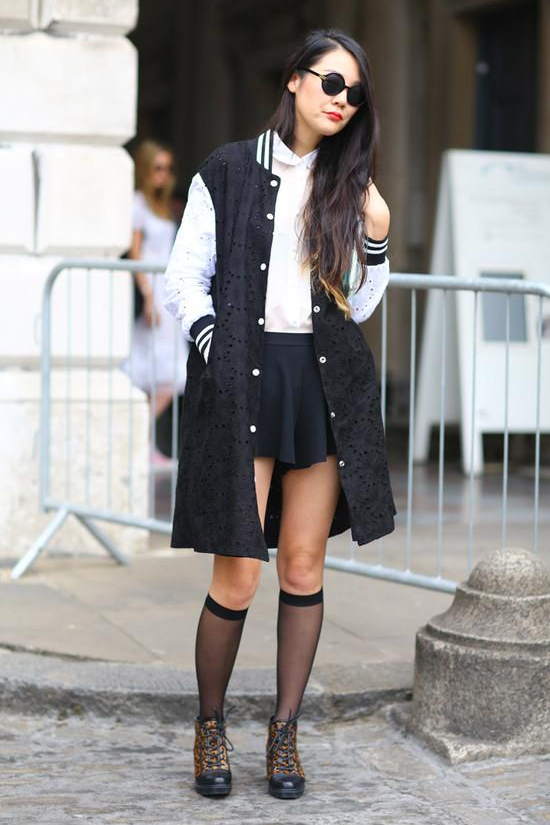

In [4]:
# Display the first image
images[0]

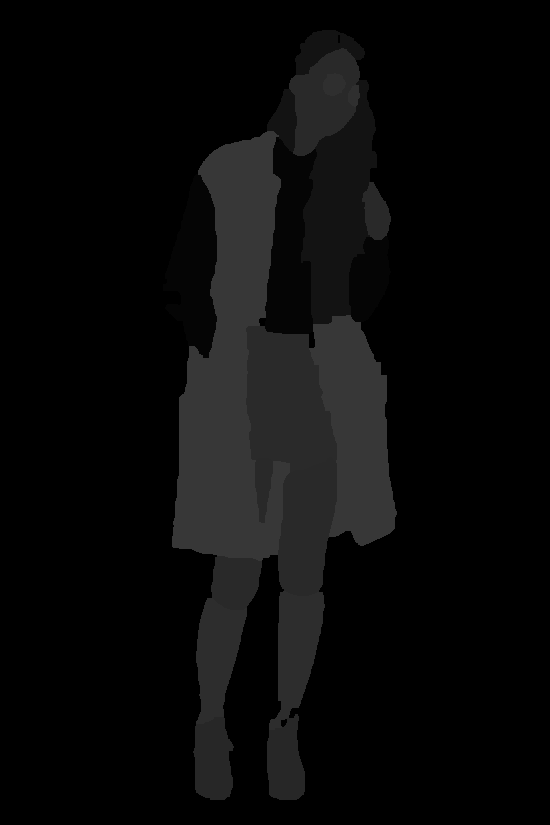

In [5]:
# Display the first corresponding mask
masks[0]

In [6]:
# Check the length of the datasets
len(images), len(masks)

(1000, 1000)

## 3. Model to identify object in the picture

### 3.1 Preprocessing - Resizing images

In [7]:
# Funtion to resize the images and masks
def resize_image(image, is_image):
   '''
   The function resizes the image/mask

   :param image: The image or mask that needs to be resized
   :type image: PngImageFile
   :param is_image: True if image / False if mask
   :type is_image: bool
   :return: image
   :rtype: tf.float32 (for image) or tf.uint8 (for mask)
   
   '''
   # Target size of the image
   target_size = (128,128)
   # If image
   if is_image:
      # Convert to floating point numpy arrays and normalize
      image = tf.cast(image, tf.float32) / 255
      # Resize the image
      image = tf.image.resize(image, target_size)
   else:
      image = np.expand_dims(image, axis=-1) 
      # Cast it
      image = tf.cast(image, tf.uint8)
      # Resize the image
      image = tf.image.resize(image, target_size, method="nearest")
      
   # Return the resized image or mask
   return image

In [8]:
# Resize images
X = [resize_image(image, True) for image in images]
# Resize masks
y = [resize_image(mask, False) for mask in masks]

### 3.3 Splitting the code

In [9]:
# Split data into 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                      random_state=14)

### 3.3 Augmentation

In [10]:
# Funtion to augment the images and masks
def image_augmentation(image, is_image):
    '''
    The function augments the images or masks

    :param image: The image/mask that needs to be resized
    :type image: tf.float32 (for image) or tf.uint8 (for mask)
    :param is_image: True if image / False if mask
    :type is_image: bool
    :return: augmentented_images
    :rtype: list
   
    '''
    
    # List to hold the augmentented images
    augmentented_images=[]

    # Augmentation for images only
    if is_image:
        # Adjust brightness
        augmentented_images.append(tf.image.adjust_brightness(image, 0.5))

        # Adjust contrast
        augmentented_images.append(tf.image.adjust_contrast(image, 0.5))

        # Adjust gamma
        augmentented_images.append(tf.image.adjust_gamma(image, 0.5))

        # Adjust hue
        augmentented_images.append(tf.image.adjust_hue(image, 0.5))

        # Adjust saturation
        augmentented_images.append(tf.image.adjust_saturation(image, 0.5))

    # Augmentation for masks only
    else:
        # The mask will be the same for images with different brightness,
        # contrast, gamma, hue, and saturation
        augmentented_images.extend([image for i in range(5)])

    # Flip the image horizontally
    augmentented_images.append(tf.image.flip_left_right(image))

    # Flip image vertically
    augmentented_images.append(tf.image.flip_up_down(image))

    # Rotate image 90 degrees
    augmentented_images.append(tf.image.rot90(image))

    # Rotate image 270 degrees
    augmentented_images.append(tf.image.rot90(image, -1))

    # Crop the image
    cropped_image = tf.image.central_crop(image, 0.8)
    # Resize after cropping
    cropped_image = tf.image.resize(cropped_image, (128,128))
    # Cast to integers as they are class numbers for masks
    if not is_image:
        cropped_image = tf.cast(cropped_image, tf.uint8)
    # Add cropped image to the list
    augmentented_images.append(cropped_image)

    # Return the list of augmented images
    return augmentented_images

In [11]:
length = len(X_train)
# Create augmented images and masks
for i in range(length):
    # Add augmented images to the images list
    X_train.extend(image_augmentation(X_train[i], True))
    # Add augmented masks to the masks list
    y_train.extend(image_augmentation(y_train[i], False))

In [12]:
# Chekc the length of the datasets
len(X_train), len(y_train)

(9900, 9900)

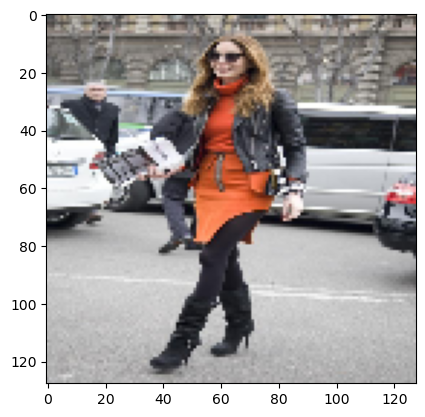

In [13]:
plt.imshow(X_train[500])

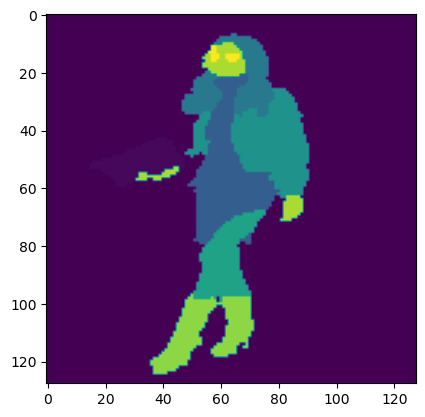

In [14]:
plt.imshow(y_train[500])

In [15]:
# develop tf Dataset objects
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)

y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

# verify the shapes and data types
X_train.element_spec, y_train.element_spec, X_test.element_spec, y_test.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [16]:
train_dataset = tf.data.Dataset.zip(X_train, y_train)
test_dataset = tf.data.Dataset.zip(X_test, y_test)

In [17]:
train_dataset = train_dataset.cache().shuffle(1000).batch(1000).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64)

## 4. U-Net CNN

In [18]:
class ModelBuilder():
    def __init__(self):
      self.down_sampling_model = None
      self.unet_model = None

    '''
      Create a unet model

      @return unet model
    '''
    def build_unet_model(self):
      # create the upsampling model using a combination of upsampling models
      upsampling_model = [
          self.build_upsampling_model(512, 4),
          self.build_upsampling_model(256, 4),
          self.build_upsampling_model(128, 4),
          self.build_upsampling_model(64, 4)
      ]

      # create the input layer using the shape of the images
      inputs = tf.keras.layers.Input(shape=[128, 128, 3])

      self.down_sampling_model = self.build_down_sampling_model()

      # store the results of the inputs going through the downsampling model
      down_sample = self.down_sampling_model(inputs)

      # store the last layer result as an output
      output = down_sample[-1]

      # store every output from the downsampling layer except the last one
      skips = reversed(down_sample[:-1])

      # loop through the upsampling model and the skips and concatenate them
      for upsample, skip in zip(upsampling_model, skips):
        output = upsample(output)
        output = tf.keras.layers.Concatenate()([output, skip])

      # downsample the output to get 59 mask potential values
      output = tf.keras.layers.Conv2DTranspose(
          filters=59,
          kernel_size=3,
          strides=2,
          padding='same')(output)

      # create and compile the UNET model
      self.unet_model = tf.keras.Model(inputs=inputs, outputs=output)
      self.compile_unet_model()

      return self.unet_model

    '''
      Compile a unet model
    '''
    def compile_unet_model(self):
      self.unet_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        metrics=['accuracy'])

    '''
      Create a fine-tuned unet model

      @return fine-tuned unet model
    '''
    def build_fine_tuned_unet_model(self):
      # enable training for the down_sampling_model (MobileNetV2)
      self.down_sampling_model.trainable = True

      # recompile the model
      self.compile_unet_model()

      return self.unet_model

    '''
      Create a down-sampling model

      @return down-sampling model
    '''
    def build_down_sampling_model(self):
      # using MobileNetV2 but any other choice could probably work here
      base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

      # Looking through the MobileNetV2 plot_model I found these blocks that
      # fit the needs of the down_sampling_model.
      skip_layer_names = [
          "block_1_expand_relu", # 128 -> 64
          "block_2_expand_relu", # 64 -> 32
          "block_5_expand_relu", # 32 -> 16
          "block_8_expand_relu", # 16 -> 8
          "block_14_expand_relu", # 8 -> 4
      ]

      # get the skip layers from the base model using the layer names
      skip_layers = [base_model.get_layer(name).output for name in skip_layer_names]

      # create the down_sampling model with the base model having training disabled
      down_stack = tf.keras.Model(inputs=base_model.input, outputs=skip_layers)
      down_stack.trainable = False

      return down_stack

    '''
      Create an up-sampling model

      @param filters - number of filters
      @param size - size of the kernel
      @return up-sampling model
    '''
    def build_upsampling_model(self, filters, size):
      initializer = tf.random_normal_initializer(0., 0.02)

      upsampling_model = tf.keras.Sequential()
      upsampling_model.add(tf.keras.layers.Conv2DTranspose(
          filters, size, strides=2,
          padding='same',
          kernel_initializer=initializer,
          use_bias=False))

      upsampling_model.add(tf.keras.layers.BatchNormalization())
      upsampling_model.add(tf.keras.layers.ReLU())

      return upsampling_model

In [19]:
class ImageViewer():
    def __init__(self):
      pass

    '''
      Show images and masks from a dataset

      @param dataset - dataset to containg images and masks to display
      @param num_to_show - an even number of images to show (default is 2)
    '''
    def show_from_dataset(self, dataset, num_to_show=2):
      plt.figure(figsize=(15,15))

      for image, mask in dataset.take(1):
        for i in range(num_to_show):
          if (i % 2) == 0:
            plt.subplot(1,2,i+1)
            plt.imshow(image)
            plt.axis('off')
          else:
            plt.subplot(1,2,i+1)
            plt.imshow(mask)
            plt.axis("off")
            plt.show()

    '''
      Plot two images side-by-side
      @param image1 -image 1
      @param image2 - image 2
    '''
    def plot_two_images(self, image1, image2):
      plt.figure(figsize=(15,15))
      plt.subplot(1,2, 1)
      plt.imshow(image1)
      plt.axis('off')

      plt.subplot(1,2, 2)
      plt.imshow(image2)
      plt.axis("off")
      plt.show()

    '''
      Show prediction

      @param image - image
      @param mask - mask
      @param pred - prediction
    '''
    def show_pred(self, image, mask, pred):
        plt.figure(figsize=(20,28))

        k = 0
        for i in pred:
            # show the predicted mask
            plt.subplot(4,3,1+k*3)
            i = tf.argmax(i, axis=-1)
            plt.imshow(i)
            plt.axis('off')
            plt.title('Prediction')

            # show the groundtruth mask
            plt.subplot(4,3,2+k*3)
            plt.imshow(mask[k])
            plt.axis('off')
            plt.title('Ground Truth')

            # show the real image
            plt.subplot(4,3,3+k*3)
            plt.imshow(image[k])
            plt.axis('off')
            plt.title('Actual')
            k += 1
            if k == 4: break

        plt.suptitle('Preditions', color='blue', size=24)
        plt.show()

In [20]:
class PerformanceReport():
    def __init__(self):
      self.conf_matrix = None

    '''
      Plot the UNET model's loss performance

      @param model_history - the unet model history
    '''
    def plot_loss_performance_charts(self, model_history):
      loss = model_history.history['loss']
      val_loss = model_history.history['val_loss']

      plt.figure()
      plt.plot(model_history.epoch, loss, 'r', label='Training loss')
      plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss Value')
      plt.ylim([0.5, 1])
      plt.legend()
      plt.show()

    '''
      Plot the UNET model's accuracy performance

      @param model_history - the unet model history
    '''
    def plot_accuracy_performance_charts(self, model_history):
      loss = model_history.history['accuracy']
      val_loss = model_history.history['val_accuracy']

      plt.figure()
      plt.plot(model_history.epoch, loss, 'r', label='Training Accuracy')
      plt.plot(model_history.epoch, val_loss, 'bo', label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy Value')
      plt.ylim([0.5, 1])
      plt.legend()
      plt.show()

    '''
      Display a confusion matrix

      @param y_true - true labels
      @param y_pred - predicted labels
    '''
    def display_confusion_matrix(self, y_true, y_pred):
      self.conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

      # plot the confusion matrix
      fig, ax = plt.subplots(figsize=(7.5, 7.5))
      ax.matshow(self.conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
      for i in range(self.conf_matrix.shape[0]):
          for j in range(self.conf_matrix.shape[1]):
              ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')

      plt.xlabel('Predictions', fontsize=14)
      plt.ylabel('Actuals', fontsize=14)
      plt.title('Confusion Matrix', fontsize=18)
      plt.show()

      # Show the confusion matrix results in a text report
      self._show_confusion_matrix_report()

      '''
        Display the results of the confusion matrix as a text report
      '''
      def _show_confusion_matrix_report(self):
        tn, fp, fn, tp = self.conf_matrix.ravel()

        print("True Positive (TP): ", tp)
        print("True Negative (TN): ", tn)
        print("False Positive (FP): ", fp)
        print("False Negative (FN): ", fn)

        accuracy = (tp + tn) / (tp + tn + fp + fn)

        precision = tp / (tp + fp)

        recall = tp / (tp + fn)

        f1_score = 2 * (precision * recall) / (precision + recall)

        print("\n\nMetrics:")
        print("Accuracy: ", round(accuracy, 2))
        print("Precision: ", round(precision, 2))
        print("Recall: ", round(recall, 2))
        print("F1-score: ", round(f1_score, 2))

In [21]:
model_builder = ModelBuilder()
unet_model = model_builder.build_unet_model()
unet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │    873,984 │ input_layer[0][0] │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 384), (None, 4,   │            │                   │
│                     │ 4, 960)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  7,866,368 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 896) │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  3,671,040 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    918,016 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    278,784 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │     85,019 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 59)               │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,693,211 (52.24 MB)

 Trainable params: 12,817,307 (48.89 MB)

 Non-trainable params: 875,904 (3.34 MB)

In [22]:
history = unet_model.fit(
    train_dataset,
    epochs=50,
    steps_per_epoch=800//64,
    validation_steps=200//64,
    validation_data=test_dataset
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 195s 16s/step - accuracy: 0.4401 - loss: 2.8250 - val_accuracy: 0.7593 - val_loss: 1.3785
Epoch 2/50


2024-08-16 15:53:10.179352: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/jaidevkler/anaconda3/envs/dev2/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 193s 16s/step - accuracy: 0.7570 - loss: 1.2299 - val_accuracy: 0.7447 - val_loss: 1.4764
Epoch 3/50


2024-08-16 15:56:23.123060: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 194s 16s/step - accuracy: 0.7598 - loss: 1.0238 - val_accuracy: 0.7217 - val_loss: 1.3537
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 194s 16s/step - accuracy: 0.7674 - loss: 0.9398 - val_accuracy: 0.7624 - val_loss: 1.0084
Epoch 5/50


2024-08-16 16:02:50.982281: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 194s 16s/step - accuracy: 0.7725 - loss: 0.9003 - val_accuracy: 0.7555 - val_loss: 0.9941
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 265s 23s/step - accuracy: 0.7786 - loss: 0.8620 - val_accuracy: 0.7666 - val_loss: 0.9517
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 687s 54s/step - accuracy: 0.7807 - loss: 0.8496 - val_accuracy: 0.7846 - val_loss: 0.8134
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2964s 267s/step - accuracy: 0.7840 - loss: 0.8422 - val_accuracy: 0.7704 - val_loss: 0.8549
Epoch 9/50


2024-08-16 17:11:20.623023: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 1/12 ━━━━━━━━━━━━━━━━━━━━ 4:06 22s/step - accuracy: 0.7931 - loss: 0.7975

KeyboardInterrupt: 

## 5. Gradio/Steamlit app 